In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tensorflow.keras import Sequential
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("train.csv")
df_test = pd.read_csv("submission.csv")

Using TensorFlow backend.


In [2]:
os.getcwd()

'D:\\codes\\torch practice\\face-mask-detection'

In [31]:
cvNet = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel')
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [4]:
df = pd.read_csv("train.csv")
df

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
...,...,...,...,...,...,...
15407,1894.jpg,437,121,907,644,face_with_mask
15408,1894.jpg,557,363,876,636,mask_surgical
15409,1894.jpg,411,3,940,325,hat
15410,3216.png,126,69,409,463,face_with_mask


In [5]:
df.iloc[0]['x1']

69

In [6]:
for i in range(100):
    if df['classname'][i] == 'face_with_mask':
        name = df['name'][i]
        x,y,w,h = df['x1'][i],df['x2'][i],df['y1'][i],df['y2'][i]
        print(name,x,y,w,h)

2756.png 69 126 294 392
2756.png 505 10 723 283
4591.png 239 9 522 342
4287.png 80 0 629 599
4893.png 179 8 664 599
1987.jpg 365 67 464 199
4070.png 154 15 493 485
3754.png 538 51 692 257
3673.png 119 26 389 379
1926.jpg 442 84 805 489
4650.png 524 287 652 384
4650.png 58 6 186 132
4650.png 251 36 286 76
3939.png 717 118 762 180
3939.png 674 134 714 174
3939.png 88 12 160 114
3939.png 62 64 107 163
4415.png 131 8 382 297
3283.png 45 27 425 476
2588.png 153 196 407 588
2618.png 348 3 518 223
4394.png 6 86 336 481
2407.png 194 10 555 514
4356.png 113 32 302 263
4356.png 768 287 845 396
4356.png 806 306 954 462
4356.png 634 221 695 301
4356.png 348 33 437 134
4356.png 497 235 581 356
4356.png 599 201 647 269
2614.png 250 8 466 285


In [7]:
for j in getJSON(os.path.join(directory,"2756.png.json")).get("Annotations"):
    print(j)

{'isProtected': False, 'ID': 598039385457921920, 'BoundingBox': [69, 126, 294, 392], 'classname': 'face_with_mask', 'Confidence': 1, 'Attributes': {}}
{'isProtected': False, 'ID': 702410169516003712, 'BoundingBox': [505, 10, 723, 283], 'classname': 'face_with_mask', 'Confidence': 1, 'Attributes': {}}
{'isProtected': False, 'ID': 152706552218535680, 'BoundingBox': [75, 252, 264, 390], 'classname': 'mask_colorful', 'Confidence': 1, 'Attributes': {}}
{'isProtected': False, 'ID': 3262639018530855, 'BoundingBox': [521, 136, 711, 277], 'classname': 'mask_colorful', 'Confidence': 1, 'Attributes': {}}


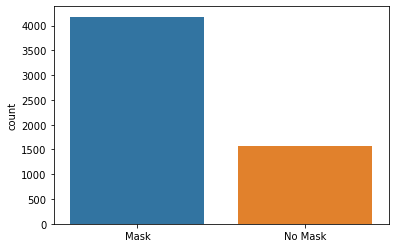

In [8]:
data = []
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
img_size = 124

for i in range(len(df)):
    if df['classname'][i] == 'face_with_mask':
        name = df['name'][i]
        x,y,w,h = df['x1'][i],df['x2'][i],df['y1'][i],df['y2'][i]
        img = cv2.imread(os.path.join(image_directory,name),1)
        img = img[y:h,x:w]
        img = cv2.resize(img,(img_size,img_size))
        data.append([img,0])
        
    if df['classname'][i] == 'face_no_mask':
        name = df['name'][i]
        x,y,w,h = df['x1'][i],df['x2'][i],df['y1'][i],df['y2'][i]
        img = cv2.imread(os.path.join(image_directory,name),1)
        img = img[y:h,x:w]
        img = cv2.resize(img,(img_size,img_size))
        data.append([img,1])
        
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)
        

        


unbalanced dataset but we got pre trained SSD model

In [9]:
X = []
Y = []
for features, label in data:
    X.append(features)
    Y.append(label)
    
    
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)
X.shape
    


(5749, 124, 124, 3)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])


xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False


)
datagen.fit(xtrain)

In [11]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=10,
                    verbose=1,
                    validation_data=(xval, yval))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
143/143 [==============================] - 51s 357ms/step - loss: 0.4370 - accuracy: 0.8362 - val_loss: 0.2586 - val_accuracy: 0.9026
Epoch 2/10
143/143 [==============================] - 48s 337ms/step - loss: 0.2663 - accuracy: 0.8929 - val_loss: 0.2209 - val_accuracy: 0.9270
Epoch 3/10
143/143 [==============================] - 48s 336ms/step - loss: 0.2737 - accuracy: 0.8888 - val_loss: 0.2563 - val_accuracy: 0.9183
Epoch 4/10
143/143 [==============================] - 48s 336ms/step - loss: 0.2604 - accuracy: 0.8973 - val_loss: 0.2134 - val_accuracy: 0.9122
Epoch 5/10
143/143 [==============================] - 48s 337ms/step - loss: 0.2400 - accuracy: 0.9017 - val_loss: 0.2052 - val_accuracy: 0.9104
Epoch 6/10
143/143 [==============================] - 48s 337ms/step - loss: 0.2457 - accuracy: 0.9045 - val_loss: 0.2152 - val_accuracy: 0.9322
Epoch 7/10
143/143 [==============================] - 

In [12]:
model.save("detection_model.h5")

[[0.00032124]]
[[0.00257766]]
[[0.32369938]]
[[1.8639745e-05]]
[[3.34965e-09]]
[[3.6219525e-09]]
[[9.025809e-12]]
[[8.449971e-11]]
[[7.0941735e-07]]
[[3.202649e-08]]
[[1.0966082e-08]]
[[0.00131352]]
[[0.00136701]]


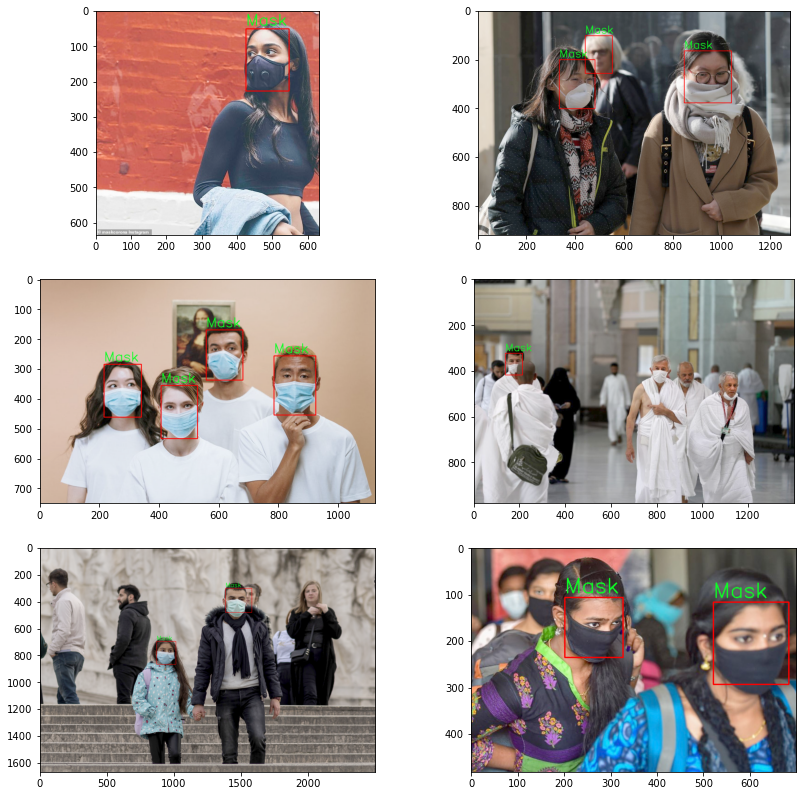

In [50]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 1.5
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            
            if confidence > 0.2:
                
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                print(result)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

[[0.95859915]]
[[0.8694504]]
[[0.9553008]]
[[0.8289359]]


C:\Users\dsdur\anaconda3\envs\zoro\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


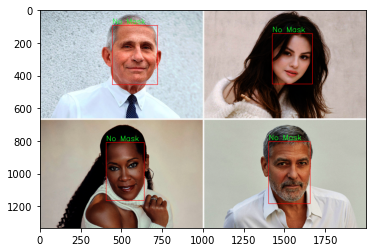

In [61]:
image =  cv2.imread(("test2.jpg"),1)
image =  adjust_gamma(image, gamma=0.5)

(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
cvNet.setInput(blob)
detections = cvNet.forward()
for i in range(0, detections.shape[2]):
    try:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        frame = image[startY:endY, startX:endX]
        confidence = detections[0, 0, i, 2]
            
        if confidence > 0.2:
                
            im = cv2.resize(frame,(img_size,img_size))
            im = np.array(im)/255.0
            im = im.reshape(1,124,124,3)
            result = model.predict(im)
            print(result)
            if result>0.5:
                label_Y = 1
            else:
                label_Y = 0
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
    except:pass
axes.append(fig.add_subplot(1, 2, 1))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
from imutils.video import VideoStream
import time
import imutils

model = load
vs = VideoStream(src=0).start()
time.sleep(2.0)
while True :
    #Get the frams from the video stream and resize to 400 px
    frame = vs.read()
    frame = imutils.resize(frame,width=400)

    # extract the dimensions , Resize image into 300x300 and converting image into blobFromImage
    (h, w) = frame.shape[:2]
    # blobImage convert RGB (104.0, 177.0, 123.0)
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]

            if confidence > 0.2:

                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                print(result)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
                
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
            if key == ord("q"):qq
            
                break
                
        except:pass

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

